In [1]:
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path("../..").absolute()))
from IPython.display import display, clear_output, Image
from three_stage_system_builder import ThreeStageSystemBuilder 
from environment import MultiStageEnv, Reward
from computation_sim.system import SystemDrawer, GifCreator, ImageCreator
from computation_sim.nodes import ConstantNormalizer
from computation_sim.time import GammaDistributionSampler, GaussianTimeSampler, Clock, DurationSampler, as_age
from matplotlib import pyplot as plt
from typing import List, Tuple
import numpy as np
import torch
from ipywidgets import widgets
from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
import tqdm
IMG_DIR = pathlib.Path("img")
IMG_DIR.mkdir(exist_ok=True)
MODEL_DIR = pathlib.Path("models")
MODEL_DIR.mkdir(exist_ok=True)
LOG_DIR = pathlib.Path("logs")
LOG_DIR.mkdir(exist_ok=True)
DELTA_T = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Set-up some default parameters
PARAMS = {
    "environment" : {
        "dt": DELTA_T, 
    },
    "draw_size": dict(width=1000, height=400),

}

In [3]:
class EnvBuilder:
    def __init__(self, dt = 1):
        self.input_sampler = GaussianTimeSampler(0.0, 1.0, 1.0, 100.0)
        self.input_compute_sampler = GammaDistributionSampler(5.0, 1.0, 3.0, 30.0)
        self.edge_compute_sampler = GammaDistributionSampler(3.0, 1.0, 1.0, 30.0)
        self.global_compute_sampler = GammaDistributionSampler(9.0, 1.0, 3.0, 30.0)
        self.age_normalizer = ConstantNormalizer(100.0)
        self.count_normalizer = ConstantNormalizer(1.0)
        self.occupancy_normalizer = ConstantNormalizer(1.0)
        self.dt = dt
        self.cost_message_loss = 1.0
        self.cost_output_time = 0.1 / 100.0
        self.cost_input = 0.01

    def build(self) -> MultiStageEnv:
        clock = Clock(0)
        builder = ThreeStageSystemBuilder(clock, self.age_normalizer, self.count_normalizer, self.occupancy_normalizer)

        # Set-up the sensor chains
        s0 = [
            builder.add_sensor_chain("0", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("1", 0, 100, self.input_sampler, self.input_compute_sampler),
        ]
        s1 = [
            builder.add_sensor_chain("2", 0, 100, self.input_sampler, self.input_compute_sampler),
            builder.add_sensor_chain("3", 0, 100, self.input_sampler, self.input_compute_sampler),
        ]

        # Set-up the edge nodes
        m = [
            builder.add_edge_compute("0", s0, self.edge_compute_sampler, 90.0),
            builder.add_edge_compute("1", s1, self.edge_compute_sampler, 90.0),
        ]

        # Set-up the output node
        builder.add_output_compute(m, self.global_compute_sampler, 90.0)
        builder.build()

        # Build the reward
        system_collection = builder.system_collection
        reward = Reward(clock.as_readonly(), system_collection, self.cost_message_loss, self.cost_output_time, self.cost_input)

        return MultiStageEnv(clock, system_collection, reward, self.dt)

def plot_sampler(sampler: DurationSampler, n: int = 100000) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(1, 1)
    samples = [sampler.sample() for i in range(n)]
    ax.hist(samples)
    return fig, ax
    
def build_environment(params):
    builder = EnvBuilder(**params["environment"])
    env = builder.build()
    return env

def build_system_drawer(env):
    drawer = SystemDrawer()
    drawer.build(env.system.node_graph)
    drawer.fw.update_layout(**PARAMS["draw_size"])
    return drawer


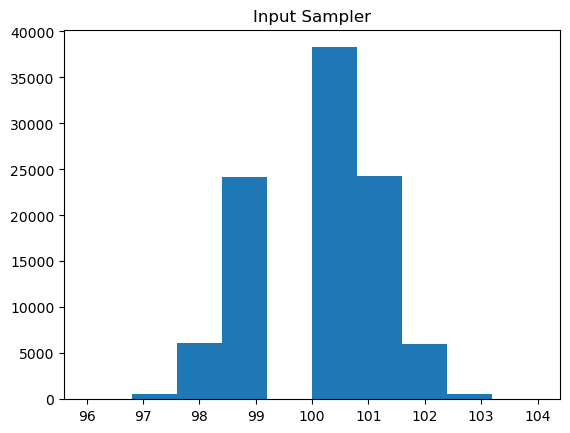

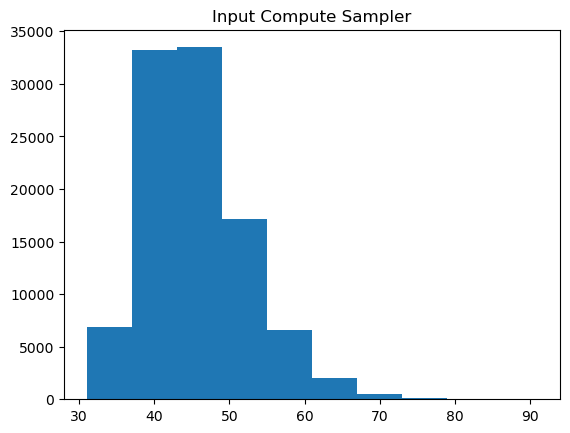

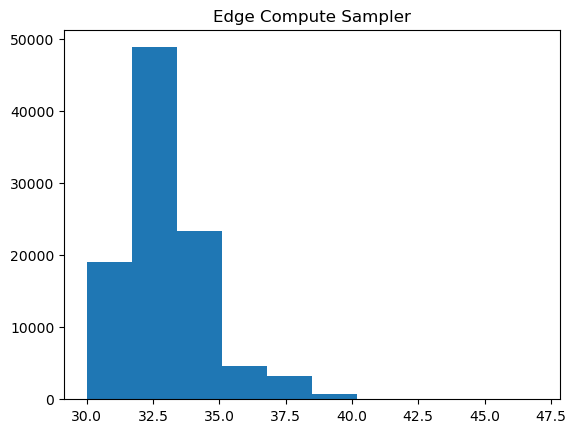

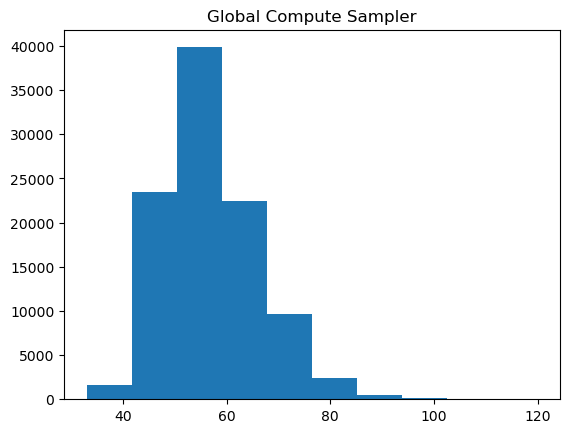

In [4]:
def plot_sampling_distributions(params):
    builder = EnvBuilder(**params["environment"])

    # Plot histograms of the execution time distributions
    fig, ax = plot_sampler(builder.input_sampler)
    ax.set_title('Input Sampler')
    fig, ax = plot_sampler(builder.input_compute_sampler)
    ax.set_title('Input Compute Sampler')
    fig, ax = plot_sampler(builder.edge_compute_sampler)
    ax.set_title('Edge Compute Sampler')
    fig, ax = plot_sampler(builder.global_compute_sampler)
    ax.set_title('Global Compute Sampler')
    
clear_output(True)
plot_sampling_distributions(PARAMS)

In [5]:
class Interact:
    def __init__(self, env):
        self.env = env
        self.drawer = build_system_drawer(self.env)
        self.state, _ = env.reset()
        self.label = widgets.HTML(
            value="<b>Action Inputs</b> (Check to enable)",
        )
        self.check_boxes = [widgets.Checkbox(value=False, description=action.name, indent = 0) for action in self.env.system.actions]
        self.button = widgets.Button(description = 'Run Timestep')   
        self.button.on_click(self.update)
        self.output = widgets.Output()
        
        display(self.label, *self.check_boxes, self.button, self.output)
        with self.output:
            display(self.drawer.fw)
            clear_output(True)

    def update(self, arg):
        actions = [0 for _ in range(8)]
        num_actions = len(self.check_boxes)
        actions[-num_actions:] = [box.get_interact_value() for box in self.check_boxes]
        action = np.packbits(actions, bitorder='big')
        self.state, reward, _, _, info= self.env.step(action)
        self.drawer.update(self.env.system.node_graph)
        
        with self.output:
            print(f"Action: {action}, Reward: {reward}")
            print(f"Info: {info}")
            print(f"State: {self.state}")
            display(self.drawer.fw)
            clear_output(True)
            
def make_interactive_plot(params):
    env = build_environment(params)
    interact = Interact(env)
    ImageCreator.save(interact.drawer, IMG_DIR / "system.jpg")

make_interactive_plot(PARAMS)



HTML(value='<b>Action Inputs</b> (Check to enable)')

Checkbox(value=False, description='EDGE_CMP_0_ACT', indent=False)

Checkbox(value=False, description='EDGE_CMP_1_ACT', indent=False)

Checkbox(value=False, description='OUTPUT_CMP_ACT', indent=False)

Button(description='Run Timestep', style=ButtonStyle())

Output()

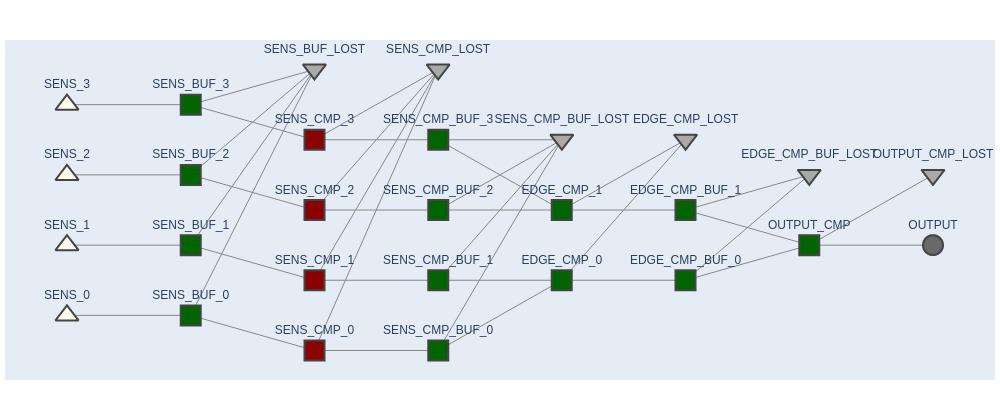

In [6]:
# Generate gh preview
with open(str(IMG_DIR / 'system.jpg'),'rb') as f:
    display(Image(data=f.read(), format='png'))